In [1]:
#from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np

import time

from bilby.core.prior import Uniform
#from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

import hphc5

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 1024.
duration = 4.

In [3]:
# Here we define our source model - this is the sine-Gaussian model in the
# frequency domain.
def eccentric_waveform(frequency_array, mass_1, mass_2, eccentricity, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec):
    
    N = len(frequency_array)
    h_plus = np.zeros(N)*1j
    h_cross = np.zeros(N)*1j
    
    fmin = 20.0
    fmax = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
    
    k = 0
    for f in frequency_array:
        if f>=fmin and f<=fmax:        
            arg_plus = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':1.0, 'Fc_':0.0, 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

            arg_cross = {'iota_':theta_jn, 'beta_':psi, 'D_':luminosity_distance , 'm1_':mass_1, 'm2_':mass_2, 'f_':f, 'f0_':20.0, 'Fp_':0.0, 'Fc_':1.0, 'et0_':eccentricity, 'phic_':phase, 'tc_':geocent_time}

            fplus = hphc5.Fn(**arg_plus)
            h_plus[k] = fplus.htilde()

            fcross = hphc5.Fn(**arg_cross)
            h_cross[k] = fcross.htilde()
            
        k=k+1

    return {'plus': h_plus, 'cross': h_cross}

In [4]:
test_frequency = np.arange(10,10000,1)
t0 = time.time()
data = eccentric_waveform(test_frequency, 35.0 ,30.0 , 0.1, 440.0, 0.4, 0.1, 1.2, 1180002601.0, 1.375, -1.2108)
t1 = time.time()
print('Execution took {:.4f}'.format(t1 - t0))

Execution took 2.3508


In [5]:
eccentric_waveform([30,40,50], 35.0 ,30.0 , 0.1, 440.0, 0.4, 0.1, 1.2, 1180002601.0, 1.375, -1.2108)

{'plus': array([ 3.88556209e-23+2.85500002e-23j,
        -6.86715778e-24-3.36909596e-23j,
         2.37610688e-23+1.33287641e-23j]),
 'cross': array([-2.85500638e-23+3.88549861e-23j,
         3.36904216e-23-6.86713752e-24j,
        -1.33285995e-23+2.37607712e-23j])}

In [6]:
# Set up a random seed for result reproducibility.
np.random.seed(150914)

In [7]:
# We now define some parameters that we will inject
injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)

In [8]:
#waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',reference_frequency=50., minimum_frequency=10., catch_waveform_errors=True)

# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=eccentric_waveform,
    parameters=injection_parameters)

12:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.eccentric_waveform
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [9]:
# Set up interferometers.
minimum_frequency = 20.0+5.0
MM1 = 35.0
MM2 = 30.0
maximum_frequency = (C**3)/( G*(MM1+MM2)*Mo*np.pi*6**(3/2) )-5.0

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for ifo in ifos:
    ifo.minimum_frequency = minimum_frequency
    ifo.maximum_frequency = maximum_frequency
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 2)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:40 bilby INFO    : Injected signal in H1:
12:40 bilby INFO    :   optimal SNR = 58.71
12:40 bilby INFO    :   matched filter SNR = 60.16+0.11j
12:40 bilby INFO    :   mass_1 = 35.0
12:40 bilby INFO    :   mass_2 = 30.0
12:40 bilby INFO    :   eccentricity = 0.1
12:40 bilby INFO    :   luminosity_distance = 440.0
12:40 bilby INFO    :   theta_jn = 0.4
12:40 bilby INFO    :   psi = 0.1
12:40 bilby INFO    :   phase = 1.2
12:40 bilby INFO    :   geocent_time = 1180002601.0
12:40 bilby INFO    :   ra = 1.375
12:40 bilby INFO    :   dec = -1.2108
12:40 bilby INFO    : Injected signal in L1:
12:40 bilby INFO    :   optimal SNR = 46.40
12:40 bilby INFO    :   matched filter SNR = 44.80+1.10j
12:40 bilby INFO    :   mass_1 = 

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

12:40 bilby INFO    : Injected signal in H1:
12:40 bilby INFO    :   optimal SNR = 58.71
12:40 bilby INFO    :   matched filter SNR = 118.87+0.11j
12:40 bilby INFO    :   mass_1 = 35.0
12:40 bilby INFO    :   mass_2 = 30.0
12:40 bilby INFO    :   eccentricity = 0.1
12:40 bilby INFO    :   luminosity_distance = 440.0
12:40 bilby INFO    :   theta_jn = 0.4
12:40 bilby INFO    :   psi = 0.1
12:40 bilby INFO    :   phase = 1.2
12:40 bilby INFO    :   geocent_time = 1180002601.0
12:40 bilby INFO    :   ra = 1.375
12:40 bilby INFO    :   dec = -1.2108
12:40 bilby INFO    : Injected signal in L1:
12:40 bilby INFO    :   optimal SNR = 46.40
12:40 bilby INFO    :   matched filter SNR = 91.19+1.10j
12:40 bilby INFO    :   mass_1 = 35.0
12:40 bilby INFO    :   mass_2 = 30.0
12:40 bilby INFO    :   eccentricity = 0.1
12:40 bilby INFO    :   luminosity_distance = 440.0
12:40 bilby INFO    :   theta_jn = 0.4
12:40 bilby INFO    :   psi = 0.1
12:40 bilby INFO    :   phase = 1.2
12:40 bilby INFO    : 

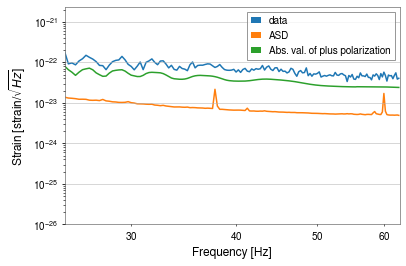

In [10]:
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

ax.set_xlim(minimum_frequency,maximum_frequency)
ax.set_ylim(1e-26,2.327737159425905e-21)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [11]:
#injection_parameters = dict(mass_1=35.0, mass_2=30.0, eccentricity=0.1, luminosity_distance=440.0, 
#theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=1.375, dec=-1.2108)
priors = bilby.core.prior.PriorDict()
priors["mass_1"] = 35.
priors["mass_2"] = 30.
priors["eccentricity"] = bilby.core.prior.LogUniform(
    name='eccentricity', latex_label='$e$', minimum=0.01, maximum=0.4)
priors["luminosity_distance"] = 440.
priors["theta_jn"] = 0.4
priors["psi"] = 0.1
priors["phase"] = 1.2
priors["geocent_time"] = 1180002601.0
priors["ra"] = 1.375
priors["dec"] = -1.2108


In [12]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

In [ ]:
result_short = bilby.run_sampler(
    likelihood, priors, sampler='dynesty', outdir='short', label="eccentric_test",
    nlive=500, dlogz=3,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True
)


12:40 bilby INFO    : Running for label 'eccentric_test', output will be saved to 'short'
12:40 bilby INFO    : Using lal version 6.21.0
12:40 bilby INFO    : Using lal git version Branch: None;Tag: lal-v6.21.0;Id: 37caf89936b637993c30b3076fe4b853311873ee;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:40 bilby INFO    : Using lalsimulation version 1.10.0
12:40 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v1.10.0;Id: 5bfe091197594d55cf634f8a1c004eb9dc9b6459;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:40 bilby INFO    : Search parameters:
12:40 bilby INFO    :   eccentricity = LogUniform(minimum=0.01, maximum=0.4, name='eccentricity', latex_label='$e$', unit=None, boundary=None)
12:40 bilby INFO    :   mass_1 = 35.0
12:40 bilby INFO    :   mass_2 = 30.0
12:40 bilby INFO    :   luminosity_distance = 440.0
12:40 bilby INFO    :   theta_jn = 0.4

0it [00:00, ?it/s]

12:54 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f85a2354a50>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:54 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:54 bilby INFO    : Using dynesty version 1.0.1
12:54 bilby INFO    : Generating initial points from the prior

543it [3:28:01, 36.70s/it, bound:0 nc: 11 ncall:1.5e+03 eff:36.1% logz-ratio=8306.66+/-0.14 dlogz:103.021>3] 

16:22 bilby INFO    : Written checkpoint file short/eccentric_test_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
16:22 bilby WARNING : Axis limits cannot be NaN or Inf
16:22 bilby WARNING : Failed to create dynesty run plot at checkpoint


799it [6:10:34, 30.27s/it, bound:0 nc:  3 ncall:2.5e+03 eff:31.9% logz-ratio=8353.07+/-0.14 dlogz:55.997>3] 

19:05 bilby INFO    : Written checkpoint file short/eccentric_test_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:05 bilby WARNING : Axis limits cannot be NaN or Inf
19:05 bilby WARNING : Failed to create dynesty run plot at checkpoint


973it [8:47:51, 102.44s/it, bound:0 nc: 20 ncall:3.5e+03 eff:27.6% logz-ratio=8372.74+/-0.14 dlogz:35.967>3]

21:42 bilby INFO    : Written checkpoint file short/eccentric_test_resume.pickle
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:42 bilby WARNING : Axis limits cannot be NaN or Inf
21:42 bilby WARNING : Failed to create dynesty run plot at checkpoint


1104it [11:12:27, 114.47s/it, bound:0 nc: 18 ncall:4.5e+03 eff:24.4% logz-ratio=8384.07+/-0.14 dlogz:24.363>3]

00:07 bilby INFO    : Written checkpoint file short/eccentric_test_resume.pickle
00:07 bilby INFO    : Writing 105 current samples to short/eccentric_test_samples.dat
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:07 bilby WARNING : Axis limits cannot be NaN or Inf
00:07 bilby WARNING : Failed to create dynesty run plot at checkpoint


1170it [12:35:06, 76.95s/it, bound:0 nc:  4 ncall:5.1e+03 eff:23.1% logz-ratio=8389.20+/-0.14 dlogz:19.082>3] 

In [17]:
len(result_short.samples)

1779